# Prepare and store data

In [1]:
import os
os.chdir("../../.")
os.getcwd()

'/Users/lovhag/Documents/Projects/cupid'

In [ ]:
import pandas as pd
from matplotlib import pyplot as plt

/Users/lovhag/Documents/Projects/cupid/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load data

Concatenate all datasets (CounterFact, ConflictQA, DRUID), corresponding model predictions for one prompt setting (zero-shot or optimal prompt template) (described under "Get Model Predictions" in the README), and corresponding detected properties (described in "Context Characteristics Detection" in the README). Store the resulting dataset in a pandas dataframe called `data` in this notebook.

In [ ]:
# concatenate the datasets as described above and save them to 'data'
# data = pd.concat(...)

## Context characteristics refinement and detection

We perform some additional minor feature refinements and property detection before checkpointing the dataset with all context properties and model predictions.

In [32]:
# define factcheck sources as reliable
if "unreliable_mbfc" in data.columns:
    data["unreliable_mbfc"] = data.apply(lambda row: False if row.is_factcheck_article else row.unreliable_mbfc, axis=1)

# add checks for mentions of 'True', or 'False' in the evidence
data["evidence_contains_true"] = data.evidence.apply(lambda val: "true" in val.lower())
data["evidence_contains_false"] = data.evidence.apply(lambda val: "false" in val.lower())

# check if claim was published after train date (for Llama)
if "claim_date" in data.columns:
    train_date = "2024-06"
    data["claim_published_before_train"] = data.claim_date<train_date
    data["claim_published_before_train"] = data.apply(lambda row: True if "borderlines" in row.claim_id else row.claim_published_before_train, axis=1)

# reformat cohere detected properties
cohere_cols = ["refers_external_source_cohere", "uncertain_cohere", "unreliable_cohere", "implicit_cohere"]
for col in cohere_cols:
    if col in data.columns:
        data[col] = data[col].replace({"Yes": True, "No": False})

Add targeted Jaccard sim (denoted as _claim-evidence overlap_ in the paper)

In [33]:
import nltk
nltk.download('punkt_tab')
from string import punctuation
from nltk.tokenize import word_tokenize

SKIPLIST = set(list(punctuation) + ["”", "“", "—", "’", "``", "''", "..."])

# add targeted Jaccard sim (focus on claim)
def get_targeted_jaccard_sim(claim, evidence):
    words_c = set([w.lower() for w in word_tokenize(claim) if w.lower() not in SKIPLIST])
    words_e = set([w.lower() for w in word_tokenize(evidence) if w.lower() not in SKIPLIST])
    return len(words_c.intersection(words_e))/len(words_c)

data["targeted_jaccard_sim"] = data.apply(lambda row: get_targeted_jaccard_sim(row.claim, row.evidence), axis=1)

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/lovhag/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


## Model prediction refinement

We also refine the model predictions in the dataset by measuring the scaled difference in output probability and check for alignment between predictions, memory and context.

### Get scaled change in p

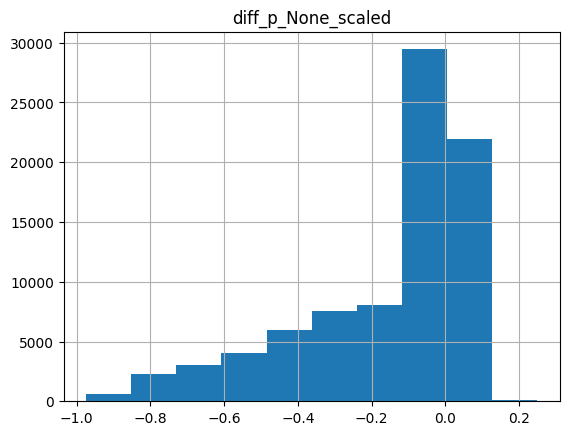

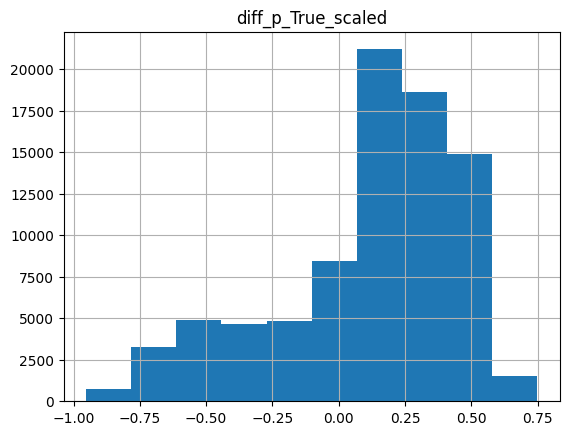

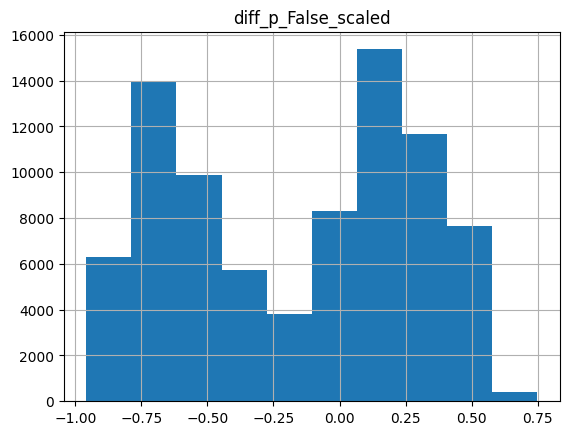

In [ ]:
def get_scaled_p_diff(p_w, p_wo):
    if p_w is None:
        return None
    # scale by how much the model can move in p space
    if p_w < p_wo:
        return (p_w-p_wo)/p_wo
    else:
        return (p_w-p_wo)/(1-p_wo)
    
data["diff_p_None_scaled"] = data.apply(lambda row: get_scaled_p_diff(row["p_None_w_evidence"], row["p_None_wo_evidence"]), axis=1)
data["diff_p_True_scaled"] = data.apply(lambda row: get_scaled_p_diff(row["p_True_w_evidence"], row["p_True_wo_evidence"]), axis=1)
data["diff_p_False_scaled"] = data.apply(lambda row: get_scaled_p_diff(row["p_False_w_evidence"], row["p_False_wo_evidence"]), axis=1)

data.diff_p_None_scaled.hist()
plt.title("diff_p_None_scaled")
plt.show()

data.diff_p_True_scaled.hist()
plt.title("diff_p_True_scaled")
plt.show()

data.diff_p_False_scaled.hist()
plt.title("diff_p_False_scaled")
plt.show()

### Get memory conflicts, whether model prediction aligns with evidence and whether model switched prediction based on provided evidence

In [ ]:
# get memory conflicts
pred_matches = {"supports": ["supports", "insufficient-supports"],
                "refutes": ["refutes", "insufficient-refutes"]}

def is_memory_conflict(row):
    if row["evidence_stance"] is None or row["evidence_stance"] == "not_applicable" or row["prediction_wo_evidence_claim_prompt_stance"] is None:
        return None
    if (row["prediction_wo_evidence_claim_prompt_stance"] == "insufficient-neutral") or (row["evidence_stance"] in ["insufficient-neutral", "insufficient-contradictory"]):
        return False
    # supports and insufficient-supports are counted as in agreement
    if row["evidence_stance"] in pred_matches[row["prediction_wo_evidence_claim_prompt_stance"]]:
        return False
    return True
                
data["memory_conflict"] = data.apply(is_memory_conflict, axis=1)
print(data.value_counts(["memory_conflict"], sort=False, dropna=False))
print()

# check whether model pred aligns with evidence
pred_matches = {"supports": ["supports"],
                "refutes": ["refutes"],
                "insufficient-neutral": ["insufficient-neutral", "insufficient-contradictory", "insufficient-supports", "insufficient-refutes"],
                "insufficient": ["insufficient-neutral", "insufficient-contradictory", "insufficient-supports", "insufficient-refutes"]}

def is_pred_aligned_w_evidence(row):
    if row["evidence_stance"] is None or row["evidence_stance"] == "not_applicable" or row["prediction_w_evidence_evidence_prompt_stance"] is None:
        return None
    if row["evidence_stance"] in pred_matches[row["prediction_w_evidence_evidence_prompt_stance"]]: 
        return True
    return False

def is_pred_aligned_wo_evidence(row):
    if row["evidence_stance"] is None or row["evidence_stance"] == "not_applicable" or row["evidence_stance"] == "not applicable" or row["prediction_wo_evidence_claim_prompt_stance"] is None:
        return None
    if row["evidence_stance"] in pred_matches[row["prediction_wo_evidence_claim_prompt_stance"]]: 
        return True
    return False

data["pred_aligned_w_evidence"] = data.apply(is_pred_aligned_w_evidence, axis=1)
data["pred_aligned_wo_evidence"] = data.apply(is_pred_aligned_wo_evidence, axis=1)
print(data.value_counts(["pred_aligned_wo_evidence", "pred_aligned_w_evidence", "memory_conflict"], sort=False, dropna=True))
print()

# check whether model switched prediction based on provided evidence
def is_pred_switched(row):
    if row["prediction_w_evidence_evidence_prompt_stance"] is None:
        return None
    return row["prediction_wo_evidence_claim_prompt_stance"] != row["prediction_w_evidence_evidence_prompt_stance"]

def is_pred_switched_to_align(row):
    if row["pred_switched"] is None or row["pred_aligned_w_evidence"] is None:
        return None
    if row["pred_switched"]:
        if row["pred_aligned_w_evidence"]:
            return 1
        return -1
    return 0

data["pred_switched"] = data.apply(is_pred_switched, axis=1)
data["pred_switched_to_align"] = data.apply(is_pred_switched_to_align, axis=1)
print(data.value_counts(["pred_switched"], sort=False, dropna=False))

memory_conflict
False              49914
NaN                92397
True               26815
Name: count, dtype: int64

pred_aligned_wo_evidence  pred_aligned_w_evidence  memory_conflict
False                     False                    False               7173
                                                   True               17289
                          True                     False              15445
                                                   True                9471
True                      False                    False               3411
                          True                     False              23714
Name: count, dtype: int64

pred_switched
False            42996
True             39824
NaN              86306
Name: count, dtype: int64


## Store the data checkpoint

We now have a final dataset with all features necessary for plotting. This is checkpointed below.

In [ ]:
ZERO_SHOT_PROMPT = False # change this depending on if the loaded dataset was for a zero-shot prompt or not

In [ ]:
if ZERO_SHOT_PROMPT:
    SAVE_DATA_FILE = "data/all_data_zero_shot.tsv"
else:
    SAVE_DATA_FILE = "data/all_data.tsv"
    
data.to_csv(SAVE_DATA_FILE, sep="\t")
print("Saved data!")

/var/folders/3k/sg837cp921q0m6v8hdxlxrbwfb5x0c/T/ipykernel_76778/1673228787.py:14: DtypeWarning: Columns (1,2,3,4,5,9,10,15,23,45,48,62,63,64,65,66,67,68,69,70,71,72,81,83) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(SAVE_DATA_FILE, sep="\t")


Loaded data!
